In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

2024-05-09 11:18:54.912094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 11:18:54.912257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 11:18:55.097901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
# Configure plotting and model loading
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Utility functions
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

MAX_DIM = 512

def load_img(path_to_img, max_dim=MAX_DIM):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def clip_0_1(image):
    return tf.clip_by_value(image, 0.0, 1.0)

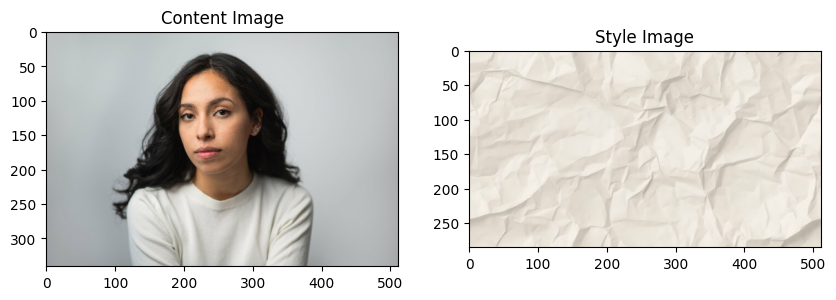

In [11]:
# Load images with consistent dimensions
content_path = '/kaggle/input/img-dls/portrait.jpeg'
style_path = '/kaggle/input/img-dls/WhatsApp Image 2024-05-05 at 16.04.49.jpeg'
content_image = load_img(content_path, max_dim=MAX_DIM)
style_image = load_img(style_path, max_dim=MAX_DIM)

# Display content and style images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [12]:
# VGG19 Layers and Feature Extraction
def vgg_layers(layer_names):
    """Creates a VGG19 model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Define Style and Content Layers
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
content_layers = ['block5_conv2']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
# Feature Extraction Model
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        return {'content': content_dict, 'style': style_dict}

# Style Content Loss Calculation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-2, content_weight=1e-4):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((gram_matrix(style_outputs[name]) - gram_matrix(style_targets[name]))**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    return style_loss + content_loss

# SSIM Loss Implementation
def ssim_loss(image1, image2, max_val=1.0):
    return 1 - tf.reduce_mean(tf.image.ssim(image1, image2, max_val=max_val))

# Combined Loss Function
def combined_loss(outputs, style_targets, content_targets, original_image, stylized_image,
                  style_weight=1e-2, content_weight=1e-4, ssim_weight=1e-2):
    sc_loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)
    ssim = ssim_loss(original_image, stylized_image)
    return sc_loss + ssim_weight * ssim

In [14]:
# Extractor Instance and Targets
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Training Step with Combined Loss
total_variation_weight = 1e-4
ssim_weight = 1e-2
style_weight = 1e-2
content_weight = 1e-4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = combined_loss(outputs, style_targets, content_targets, content_image, image,
                             style_weight, content_weight, ssim_weight)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Optimizer and Image Variable
opt = tf.optimizers.Adam(learning_rate=0.02)
image = tf.Variable(content_image)

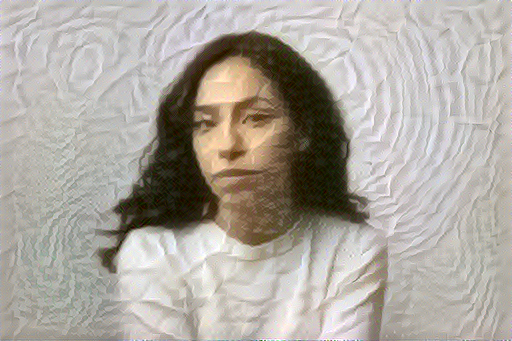

Train step: 71


In [ ]:
# Optimize Texture with VGG-based Feature Loss and SSIM
def optimize_texture_vgg(image, epochs=10, steps_per_epoch=100):
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            if m % 10 == 0:
                display.clear_output(wait=True)
                display.display(tensor_to_image(image))
                print("Train step: {}".format(step))

optimize_texture_vgg(image, epochs=5, steps_per_epoch=50)

# Display Final Stylized Image
plt.figure(figsize=(8, 8))
plt.imshow(tensor_to_image(image))
plt.title('VGG-based Stylized Image with SSIM Loss')
plt.axis('off')
plt.show()